# CQF Exam Two

## January 2024 Cohort

## Task (copied from the exam sheet)

Use the expected value of the discounted payoff under the risk-neutral density $\mathbb{Q}$

$$
V(S, t) = e^{-r(T-t)} \mathbb{E}^\mathbb{Q}\left[\textbf{Payoff}(S_T)\right]
$$

for the appropriate form of payoff, to consider **Asian** and **Lookback** options.

Use the **Euler-Maruyama** (only) scheme for initially simulating the underlying stock price. As an initial example you may use the following set of sample data:

\begin{align*}
\text{Today's stock price } S_0 & = 100 \\
\text{Strike } E & = 100 \\
\text{Time to expiry } (T - t) & = 1 \text{ year} \\
\text{Volatility } \sigma & = 20\% \\
\text{Constant risk-free interest rate } r & = 5\%
\end{align*}

Then vary the data to see the affect on the option price.

## Solution

We assume the underlying stock price process $S_t$ follows a Geometric Brownian motion

$$dS_t = rS_t dt + \sigma S_t dW_t.$$

Following [1], Euler-Maruyama method discretizes the process $S_t$ to

$$S(t+\delta t) = S(t) * \left(1+ r\delta t+\sigma  \sqrt{\delta t}\phi\right),$$

where $\phi$ is from a standardized Normal distribution. But since our SDE for the asset path is integrable, we can find the time-stepping algorithm

$$S(t+\delta t) = S(t) * \exp\left[\left(r-\frac{1}{2}\sigma^2\right)\delta t + \sigma\sqrt{\delta t}\phi\right],$$

which is what we will implement in the following.

In [31]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


np.set_printoptions(precision=3)
pd.set_option('display.precision', 4)
warnings.filterwarnings('ignore')

In [32]:
S0 = 100
K = 100
t = 1
sigma = 0.2
r = 0.05
dt = 0.01
number_of_mc_paths = 50000

Now generate 50k Monte Carlo asset paths using the discretized time-stepping algorithm for Geometric Brownian motion and store these asset simulations in an array S. Each of these 50k simulations of S will contain $(T-t)/0.01 = 100$ stock prices over the course of the observation period until the derivative options expire.

In [45]:
def simulate_stock_price(S0, r, sigma, t, dt, number_of_mc_paths=10000):
    """Simulate stock price using Euler-Maruyama method."""
    N = round(t / dt)  # number of time steps
    S = np.zeros((number_of_mc_paths, N))
    S[:, 0] = S0
    for i in range(1, N):
        dW = np.random.standard_normal(number_of_mc_paths)  # Brownian increment
        S[:, i] = S[:, i-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * dW)  # Euler-Maruyama step
    return S


S = simulate_stock_price(S0, r, sigma, t, dt, number_of_mc_paths)
# S is an array with length = <number_of_mc_paths> containing the simulated asset prices
S

array([[100.   ,  98.832,  95.911, ..., 118.297, 119.976, 121.006],
       [100.   ,  98.26 , 100.502, ..., 144.66 , 140.765, 145.092],
       [100.   ,  98.65 ,  98.07 , ..., 135.747, 132.51 , 133.815],
       ...,
       [100.   , 102.13 , 104.165, ...,  95.331,  98.089,  99.179],
       [100.   ,  98.781,  99.669, ...,  99.609, 102.117, 103.069],
       [100.   , 101.427, 102.009, ..., 143.194, 143.654, 146.598]])

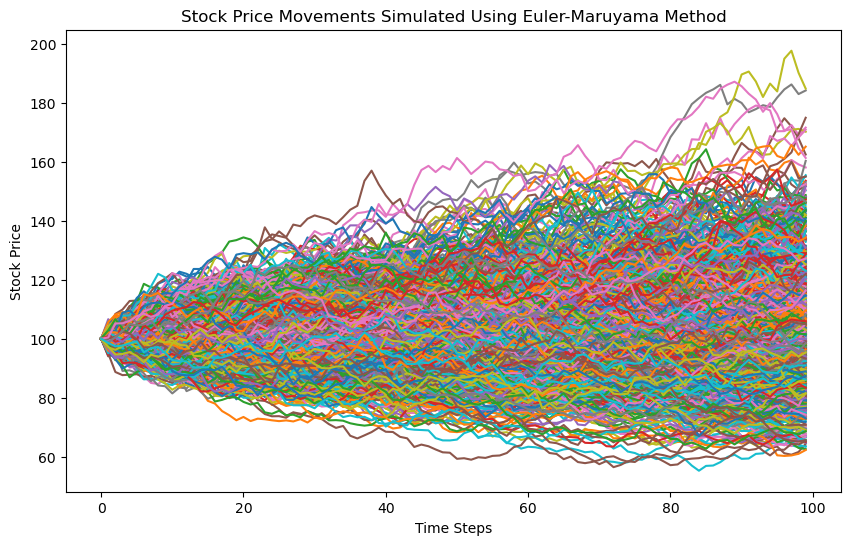

In [42]:
plt.figure(figsize=(10, 6))
for i in range(1000):  # plot the first 1000 paths
    plt.plot(S[i, :])
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Stock Price Movements Simulated Using Euler-Maruyama Method')
plt.show()

In [43]:
def calculate_asian_and_lookback_option_prices(S, K, r, t):
    """Calculate prices for Asian and Lookback call & put options."""
    avg = np.mean(S, axis=1)  # mean stock price over the path
    maxim = np.max(S, axis=1)  # maximum stock price over the path
    asian_call = np.exp(-r * t) * np.maximum(avg - K, 0)  # Asian call payoff
    asian_put = np.exp(-r * t) * np.maximum(K - avg, 0)  # Asian put payoff
    lookback_call = np.exp(-r * t) * np.maximum(maxim - K, 0)  # Lookback call payoff
    lookback_put = np.exp(-r * t) * np.maximum(K - maxim, 0)  # Lookback put payoff
    return asian_call, asian_put, lookback_call, lookback_put


option_prices = calculate_asian_and_lookback_option_prices(S, K, r, t)
option_names = ['Asian Call', 'Asian Put', 'Lookback Call', 'Lookback Put']
list(zip(option_names, option_prices))

[('Asian Call', array([5.271, 4.898, 0.   , ..., 2.404, 0.   , 0.   ])),
 ('Asian Put', array([ 0.   ,  0.   , 12.076, ...,  0.   ,  1.725,  0.605])),
 ('Lookback Call',
  array([18.103, 19.581,  5.711, ..., 18.858,  7.026,  9.637])),
 ('Lookback Put', array([0., 0., 0., ..., 0., 0., 0.]))]

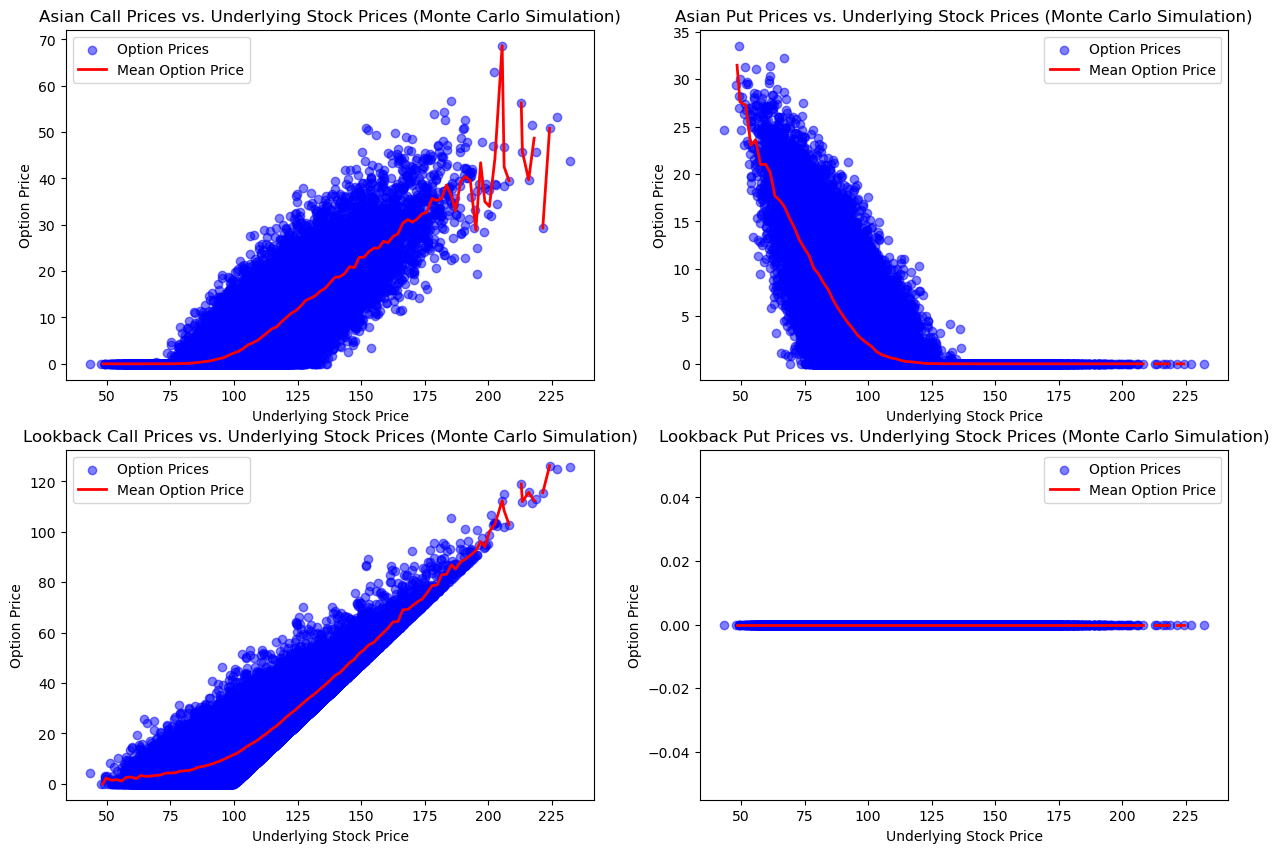

In [44]:
# Plot scatter plots of option prices vs. underlying stock prices
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()
for i in range(len(option_names)):
    # Scatter plot of option prices vs. underlying stock prices
    axs[i].scatter(S[:, -1], option_prices[i], color='blue', alpha=0.5, label='Option Prices')

    # Calculate the mean option price for each bin of stock prices
    df = pd.DataFrame({'StockPrice': S[:, -1], 'OptionPrice': option_prices[i]})
    df['StockPriceBin'] = pd.cut(df['StockPrice'],
                                 bins=np.linspace(df['StockPrice'].min(), df['StockPrice'].max(), 100))
    df_grouped = df.groupby('StockPriceBin').mean()

    # Plot the mean option price for each bin
    axs[i].plot(df_grouped['StockPrice'], df_grouped['OptionPrice'], color='red', linewidth=2,
                label='Mean Option Price')

    axs[i].set_xlabel('Underlying Stock Price')
    axs[i].set_ylabel('Option Price')
    axs[i].set_title(f'{option_names[i]} Prices vs. Underlying Stock Prices (Monte Carlo Simulation)')
    axs[i].legend()
plt.show()

In [26]:
avg_option_prices = [np.mean(price) for price in option_prices]
for i in range(len(option_names)):
    print(f"The average price for the {option_names[i]} is {avg_option_prices[i]:.2f}")

The average price for the Asian Call is 4.94
The average price for the Asian Put is 3.97
The average price for the Lookback Call is 16.04
The average price for the Lookback Put is 0.07


## References

* [1]: JA243.4 - Lecture Notes on Numerical Methods